# Fitting py3DCORE_h4c

In [14]:
%load_ext autoreload

%autoreload 2

import heliosat as heliosat
import logging as logging
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import shutil as shutil
import pandas as pds
import event as evt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

## ICMECAT

We first read the catalog and save all events in lists.

In [16]:
wincat,stacat,stbcat,pspcat,solocat,bepicat,ulycat,messcat,vexcat = evt.get_cat()

i1au = wincat + stacat + stbcat
print('ICMECAT events near 1 AU',len(i1au))

got wincat: 448
got stacat: 258
got stbcat: 150
got pspcat: 35
got solocat: 34
got bepicat: 32
got ulycat: 0
got messcat: 0
got vexcat: 93
ICMECAT events near 1 AU 856


We now choose a specific event we want to fit.

We set the launchtime for the CME, t_launch (as observed), and two points in time (t_s and t_e), that lie outside of our fitting range. These function as reference points to check, whether an ensemble is actually hitting our spacecraft within the time window. Furthermore, we set fitting points, t, to which the flux rope model will be fitted.

In [17]:
#t_launch = winevent[0].begin-datetime.timedelta(days=4)
# test

#t_launch = datetime.datetime(2020, 4, 19, 13, tzinfo=datetime.timezone.utc)

#t_s_solo = datetime.datetime(2022, 4, 19, 5, tzinfo=datetime.timezone.utc)
#t_e_solo = datetime.datetime(2022, 4, 20, 10, tzinfo=datetime.timezone.utc)

#t_solo = [
#    datetime.datetime(2022, 4, 19, 10, tzinfo=datetime.timezone.utc),
#    datetime.datetime(2022, 4, 19, 12, tzinfo=datetime.timezone.utc),
#    datetime.datetime(2022, 4, 19, 14, tzinfo=datetime.timezone.utc),
#    datetime.datetime(2022, 4, 19, 16, tzinfo=datetime.timezone.utc)
#]
t_launch = datetime.datetime(2022, 9, 5, 13, tzinfo=datetime.timezone.utc)

t_s_solo = datetime.datetime(2022, 9, 6, 12, 30, tzinfo=datetime.timezone.utc)
t_e_solo = datetime.datetime(2022, 9, 7, 1, tzinfo=datetime.timezone.utc)

t_solo = [
    datetime.datetime(2022, 9, 6, 13, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 6, 15, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 6, 17, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 9, 6, 19, tzinfo=datetime.timezone.utc)
]

Restraining the initial values for the ensemble members leads to more efficient fitting.

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [18]:
model_kwargs = {
    "ensemble_size": int(2**16), 
    "iparams": {
       "cme_longitude": {
           "maximum": 180,
           "minimum": -180
       },
       "cme_latitude": {
           "maximum": 90,
           "minimum": -90
       },
       "cme_inclination": {
           "maximum": 90,
           "minimum": 0
       }, 
        "cme_launch_velocity": {
            "maximum": 1500,
            "minimum": 250
        },
        "cme_launch_radius": {
            "maximum": 15,
            "minimum": 5
        }
    }
}

In [11]:
#"cme_launch_offset": {
#    "distribution": "uniform",
#    "maximum": 3600*24,
#    "minimum": -3600*24
#}

In [19]:
output = 'solo05092022_heeq_512/'

fitter = py3dcore_h4c.ABC_SMC()
fitter.initialize(t_launch, py3dcore_h4c.ToroidalModel, model_kwargs)
fitter.add_observer("SOLO", t_solo, t_s_solo, t_e_solo)

In [21]:
# set jobs=8, workers=8, to avoid using all CPU cores

fitter.run(ensemble_size=512, reference_frame="HEEQ", sampling_freq=3600, output=output, eps_quantile=0.25) 

ERROR:heliosat.spacecraft:failed to fetch data file "data?retrieval_type=LAST_PRODUCT&data_item_id=solo_L2_mag-rtn-normal-1-minute_20220906&product_type=SCIENCE"


Exception: no valid files to continue with

now that the fitting is completed, we look at the results.

In [15]:
# Get the list of all files 
path = output

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        #respath.append(os.path.join(path, file)) 
        resfile.append(file)
        print(os.path.join(path, file))

psp02062022_heeq_512_4FP_ts12/00.pickle
psp02062022_heeq_512_4FP_ts12/01.pickle
psp02062022_heeq_512_4FP_ts12/02.pickle
psp02062022_heeq_512_4FP_ts12/03.pickle
psp02062022_heeq_512_4FP_ts12/04.pickle
psp02062022_heeq_512_4FP_ts12/05.pickle
psp02062022_heeq_512_4FP_ts12/06.pickle
psp02062022_heeq_512_4FP_ts12/07.pickle
psp02062022_heeq_512_4FP_ts12/08.pickle
psp02062022_heeq_512_4FP_ts12/09.pickle


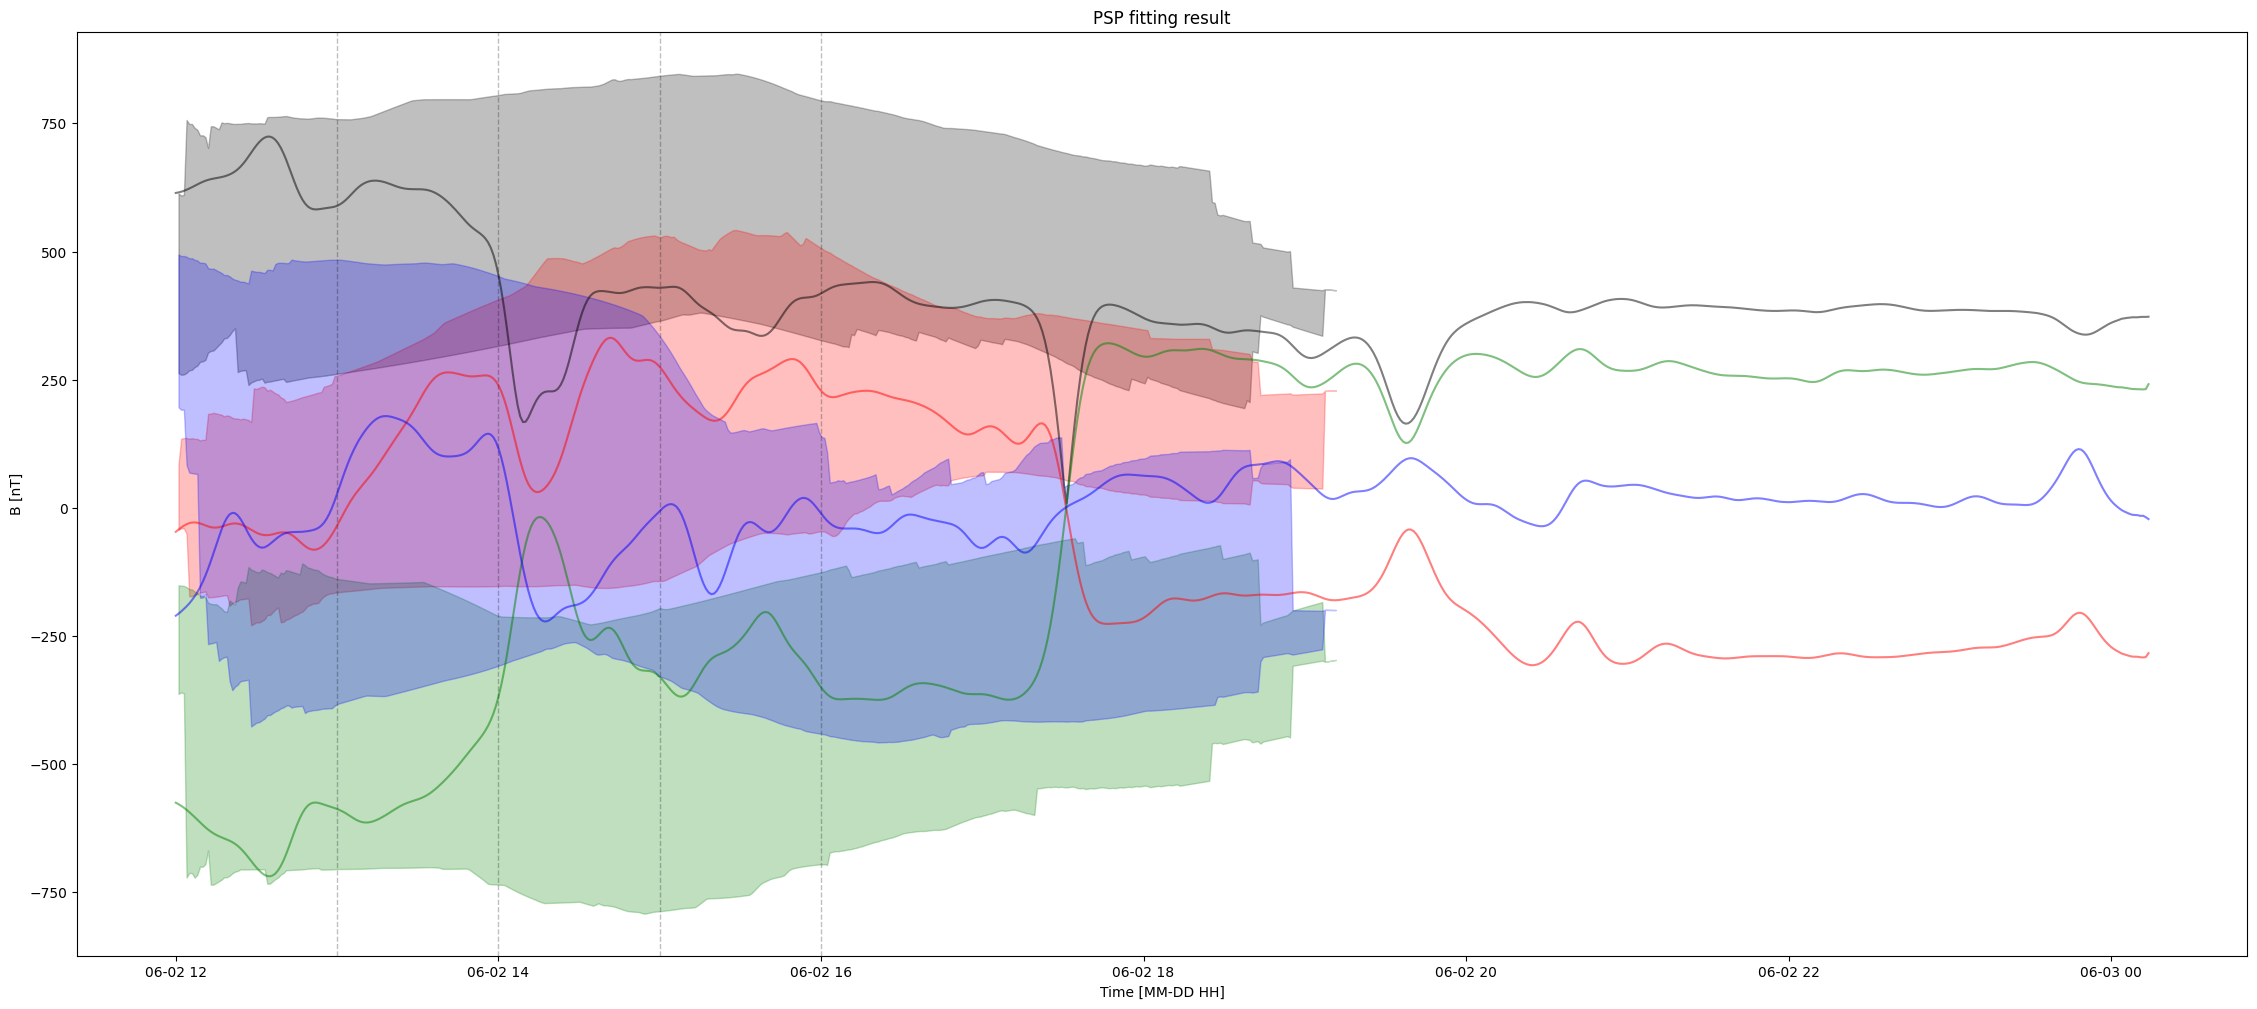

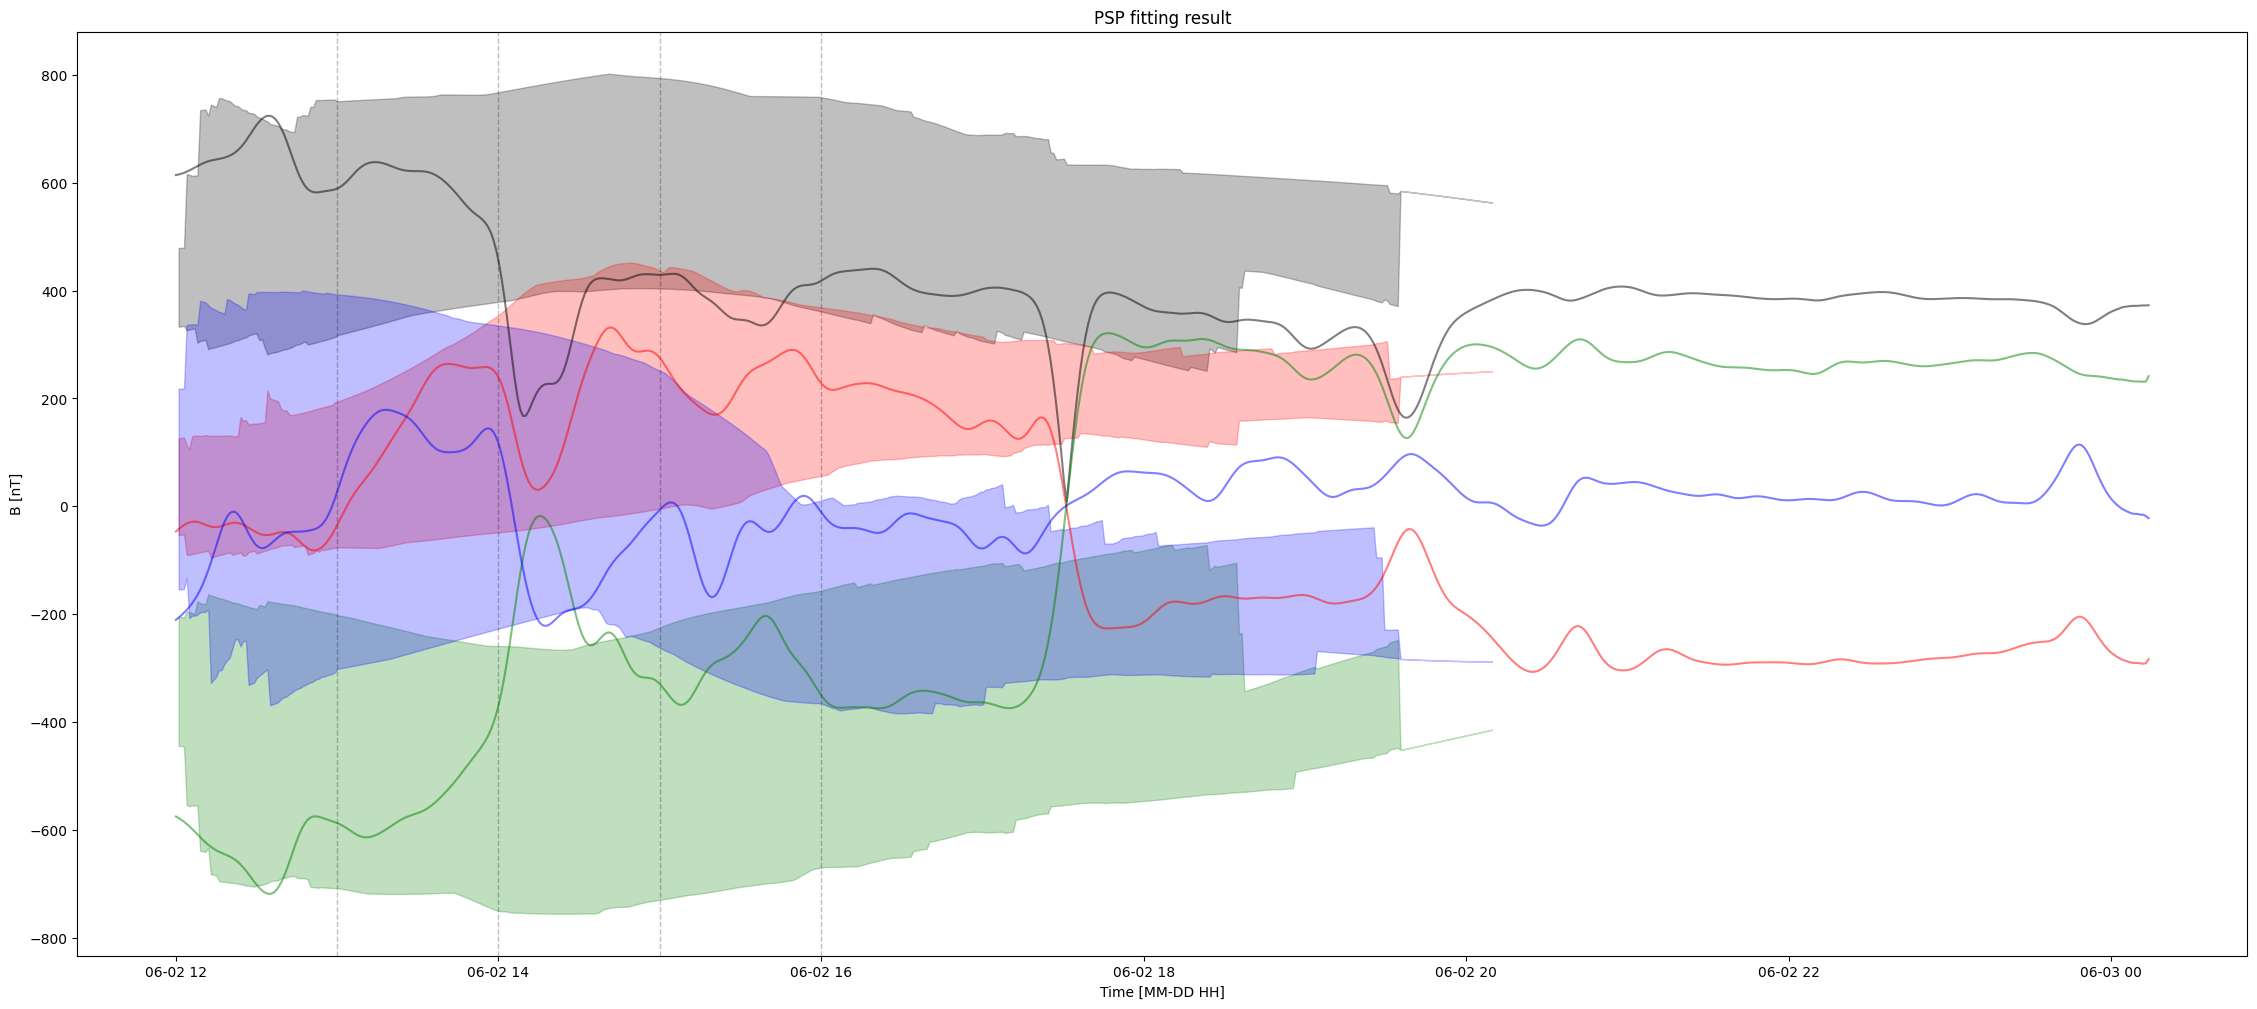

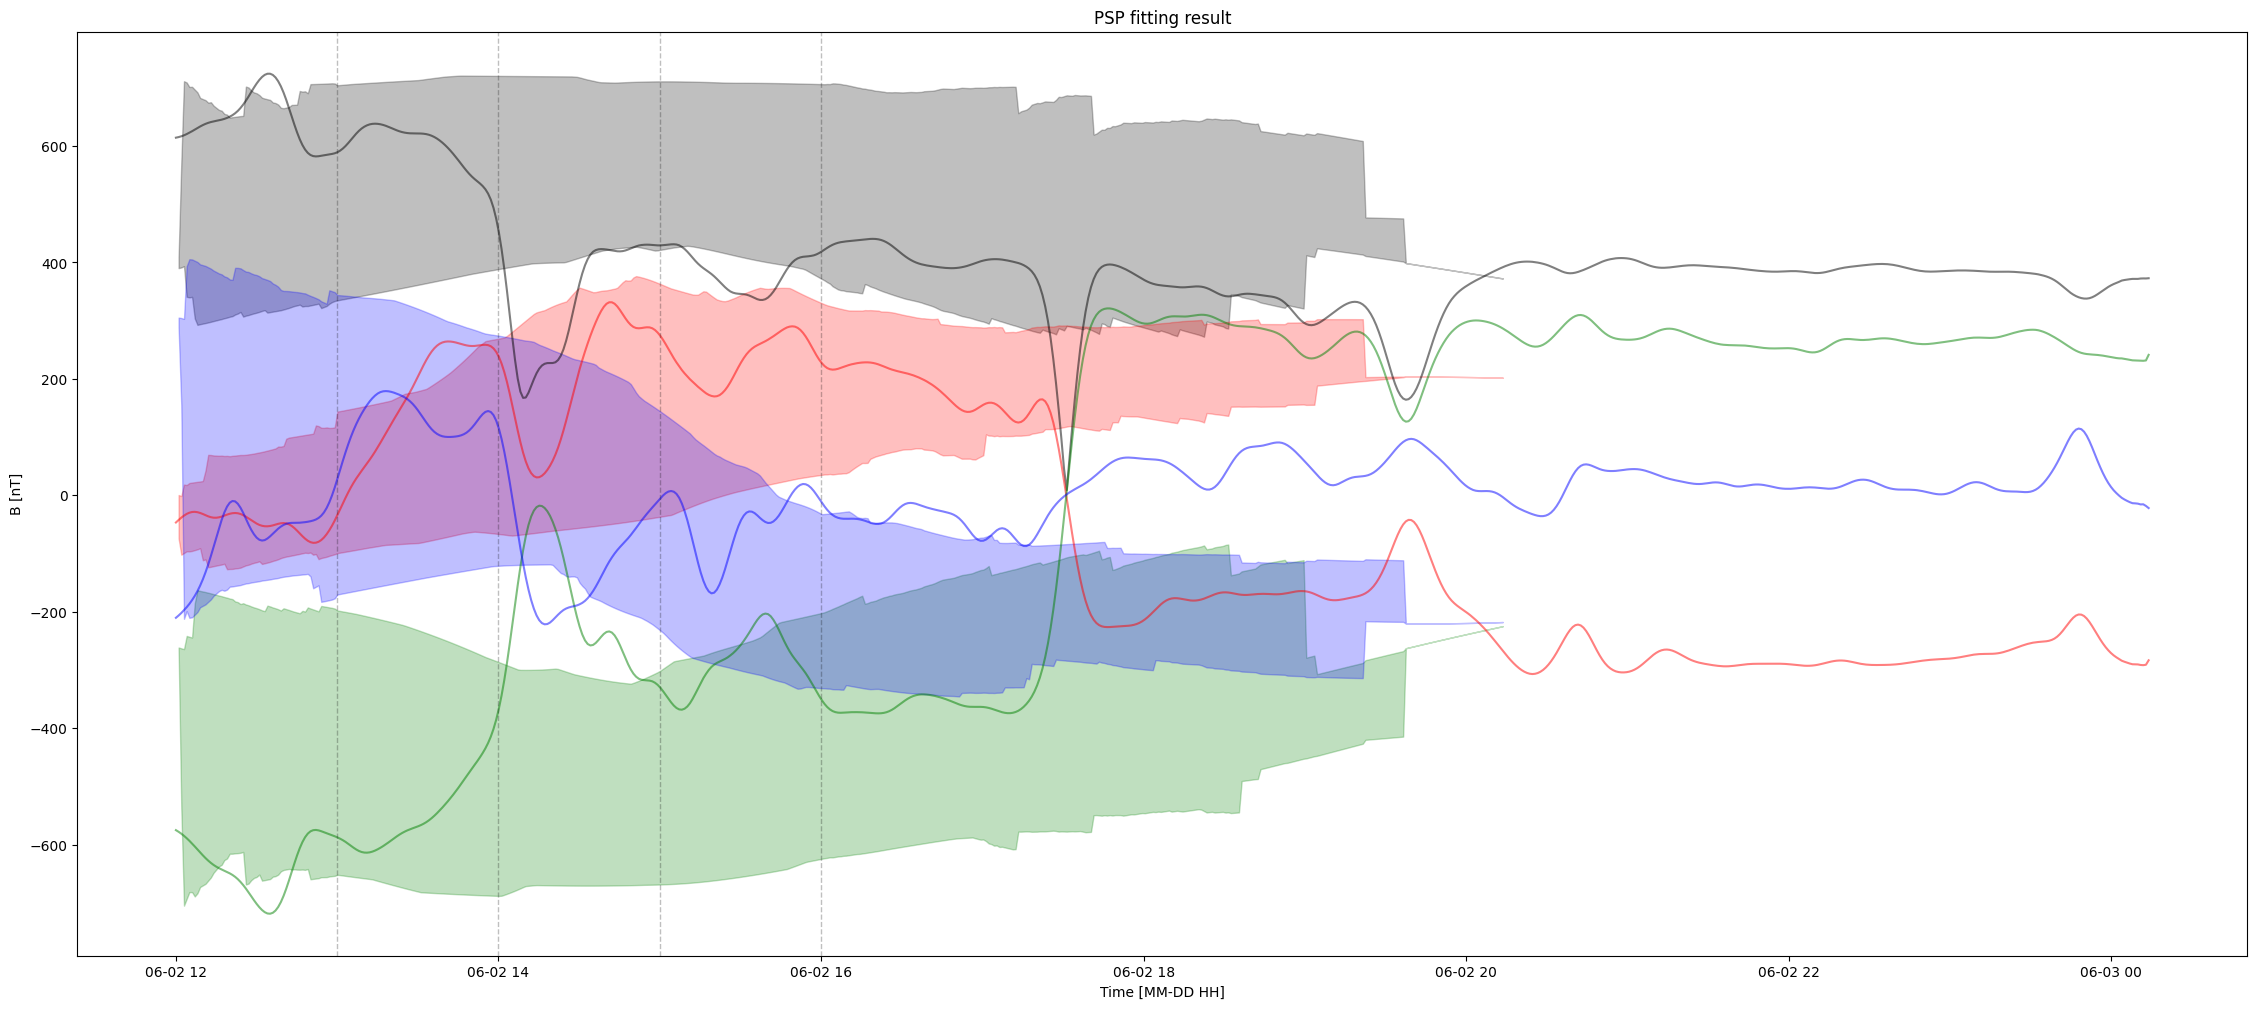

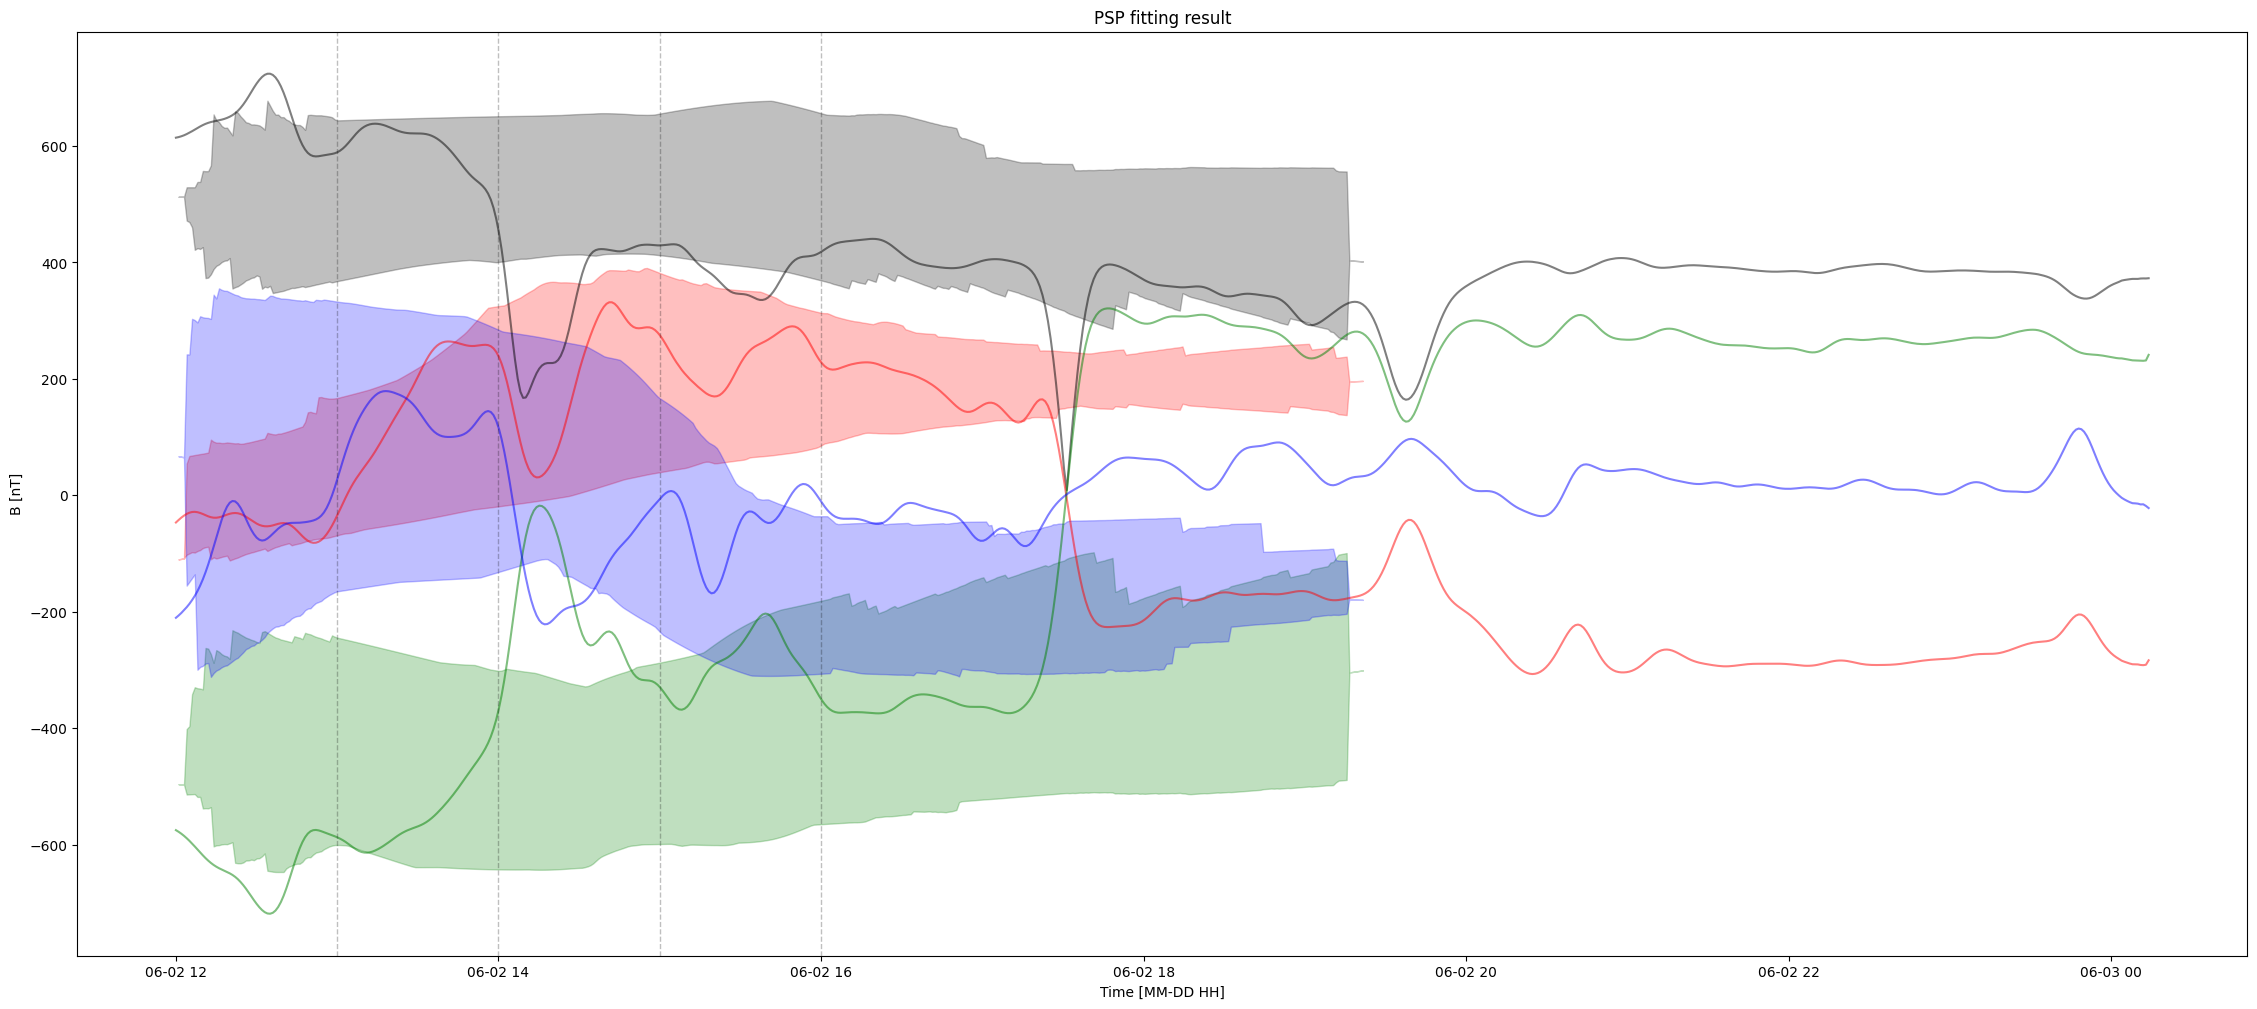

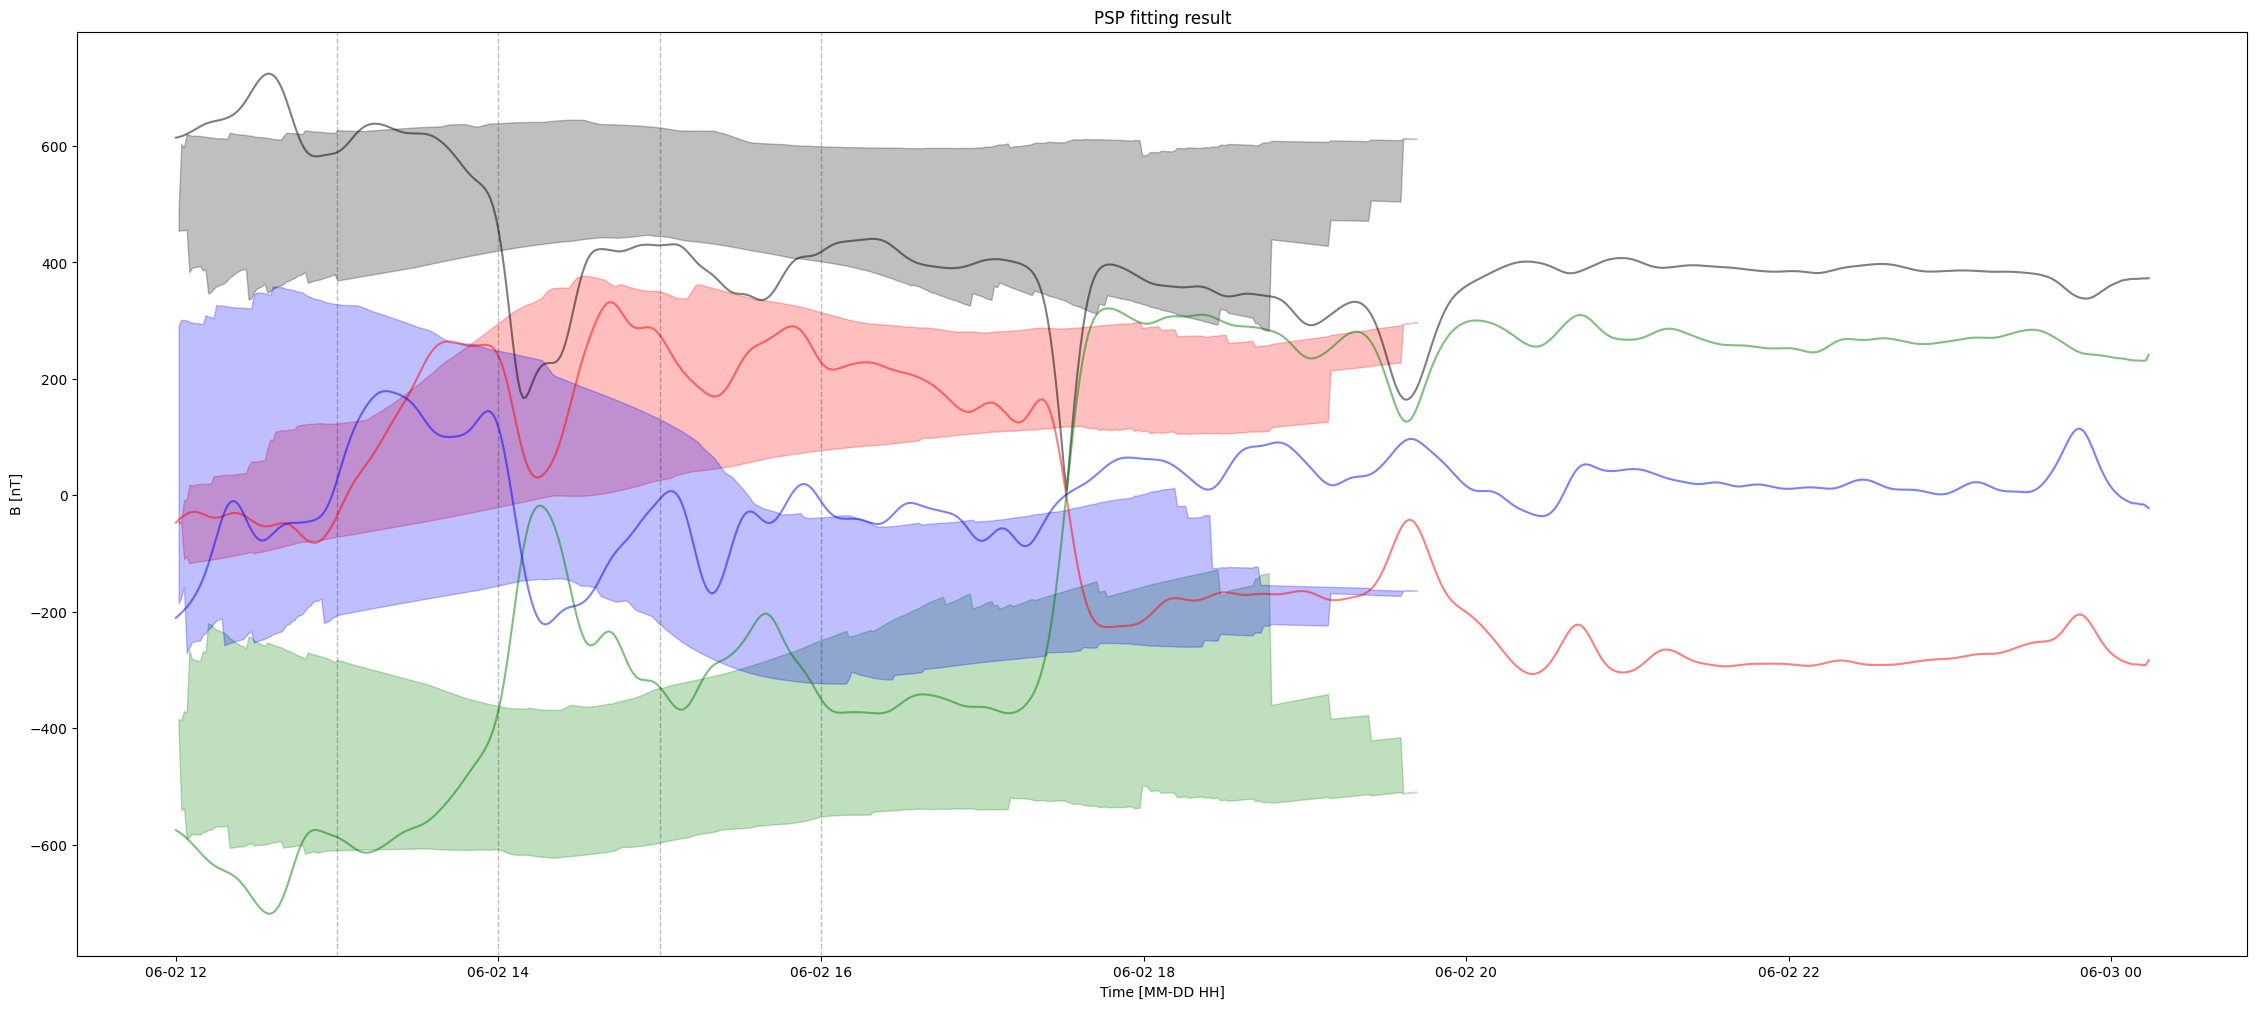

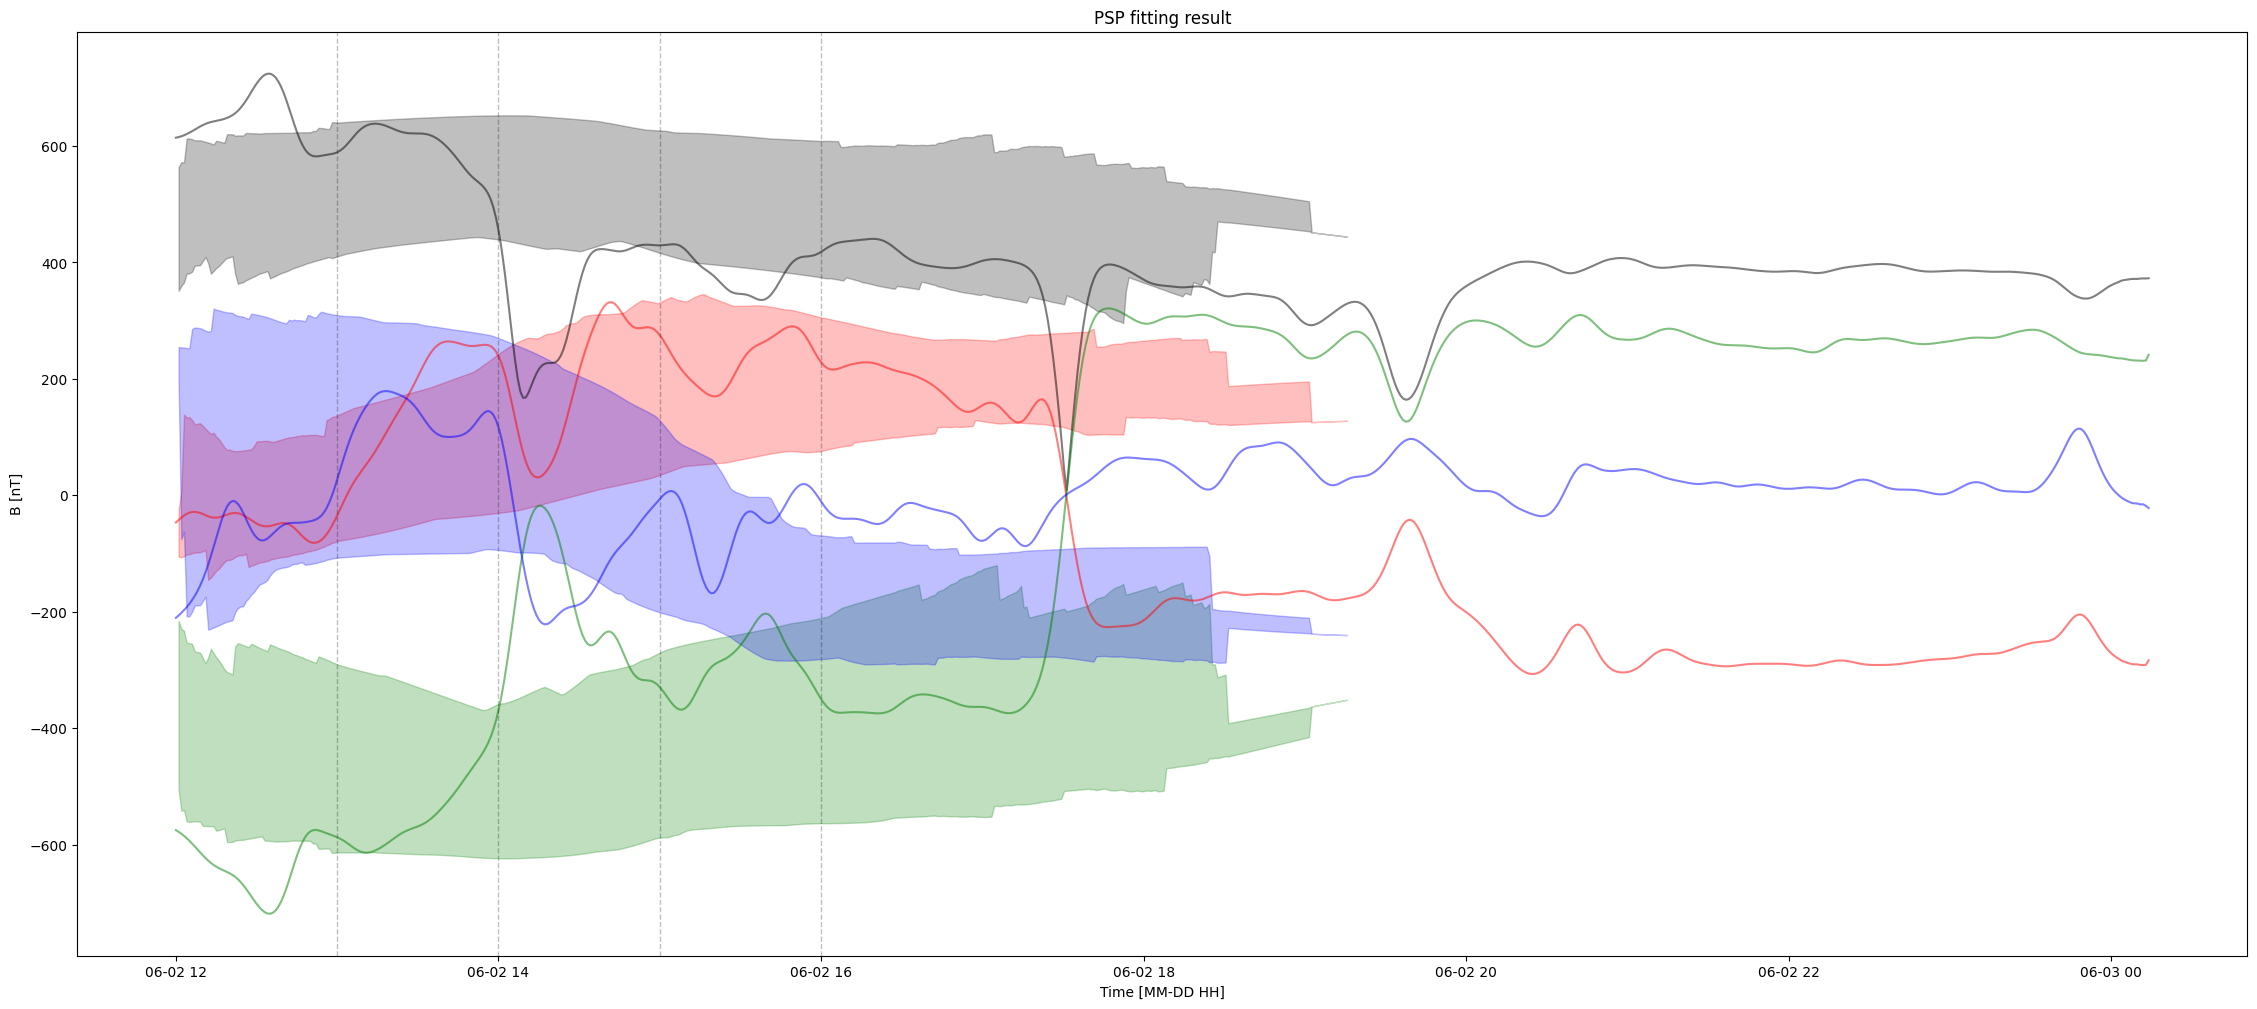

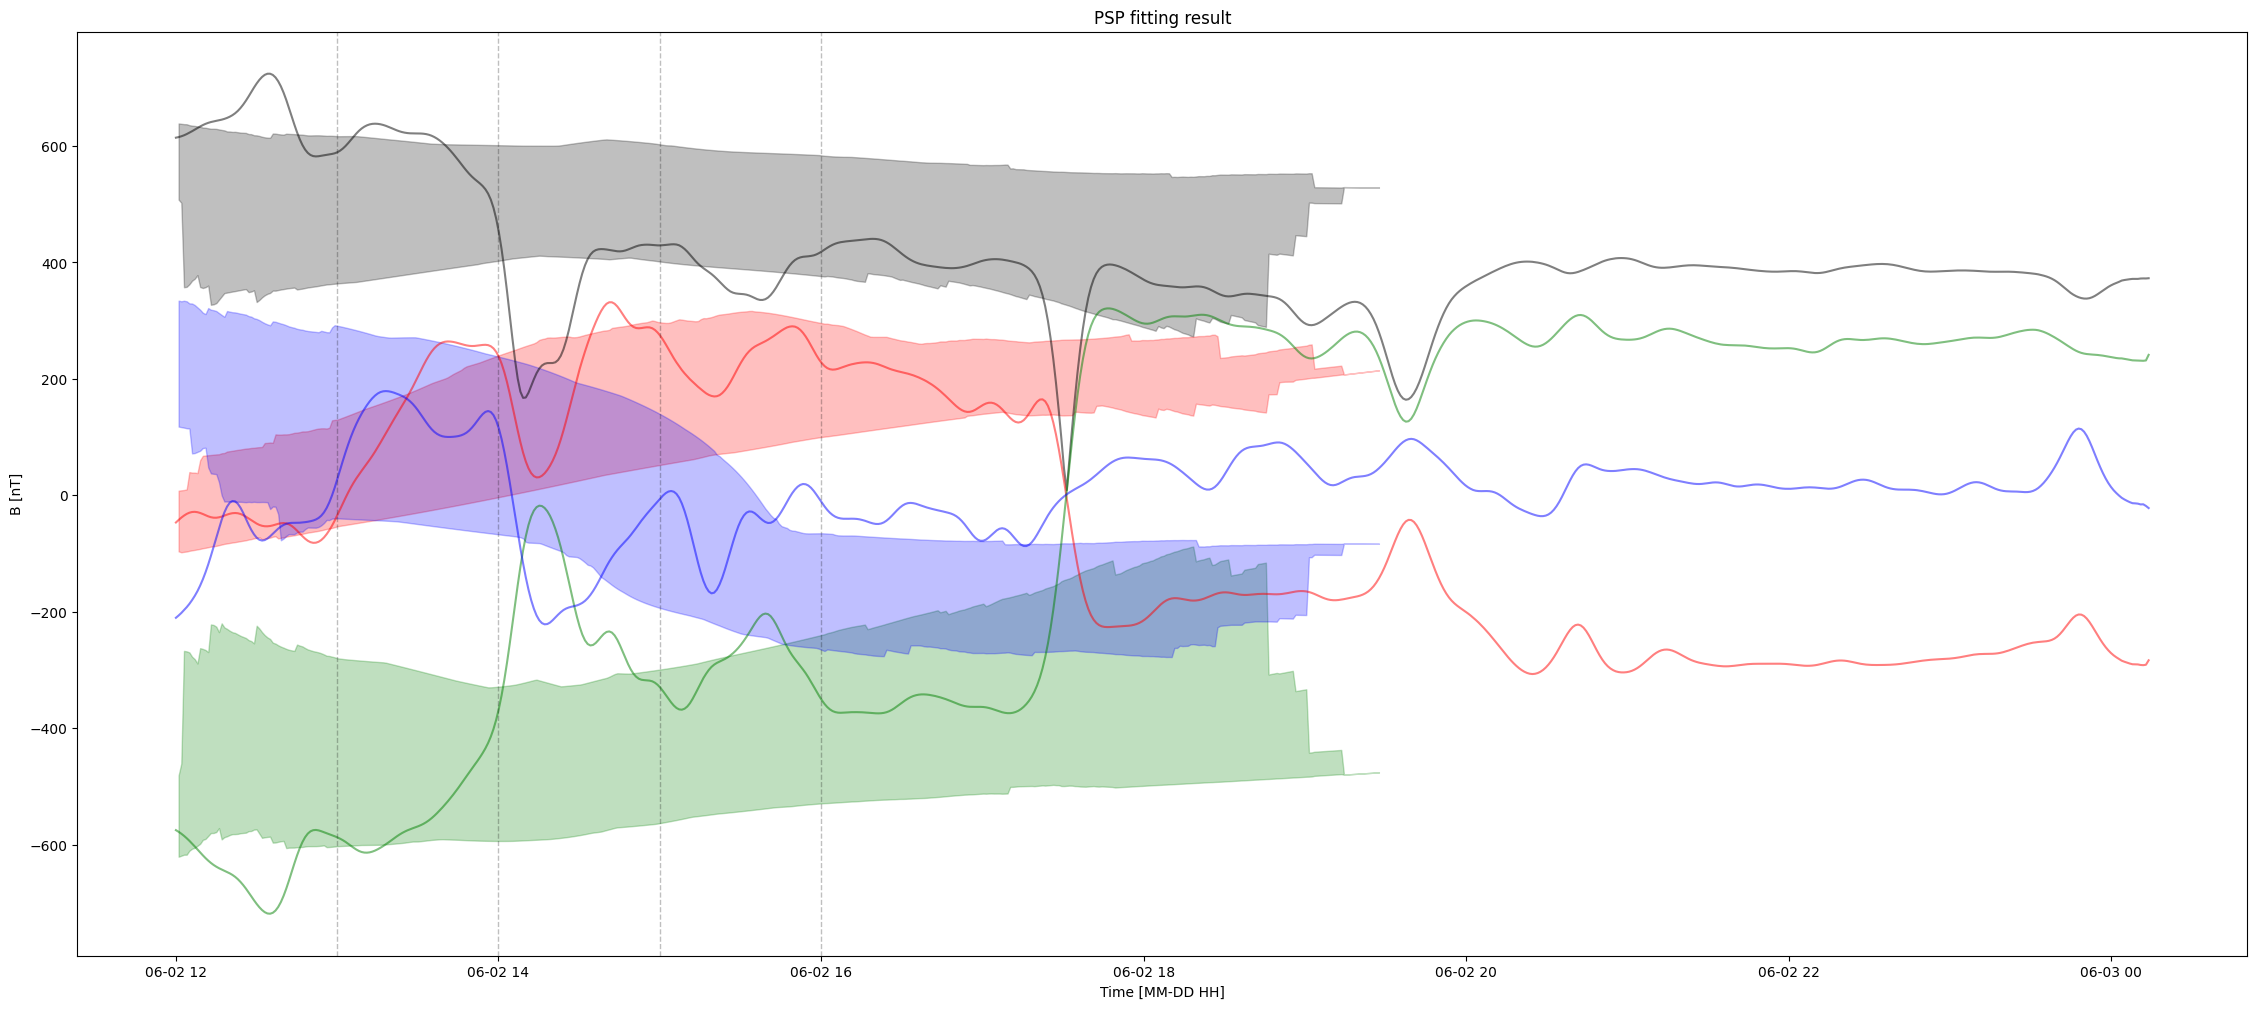

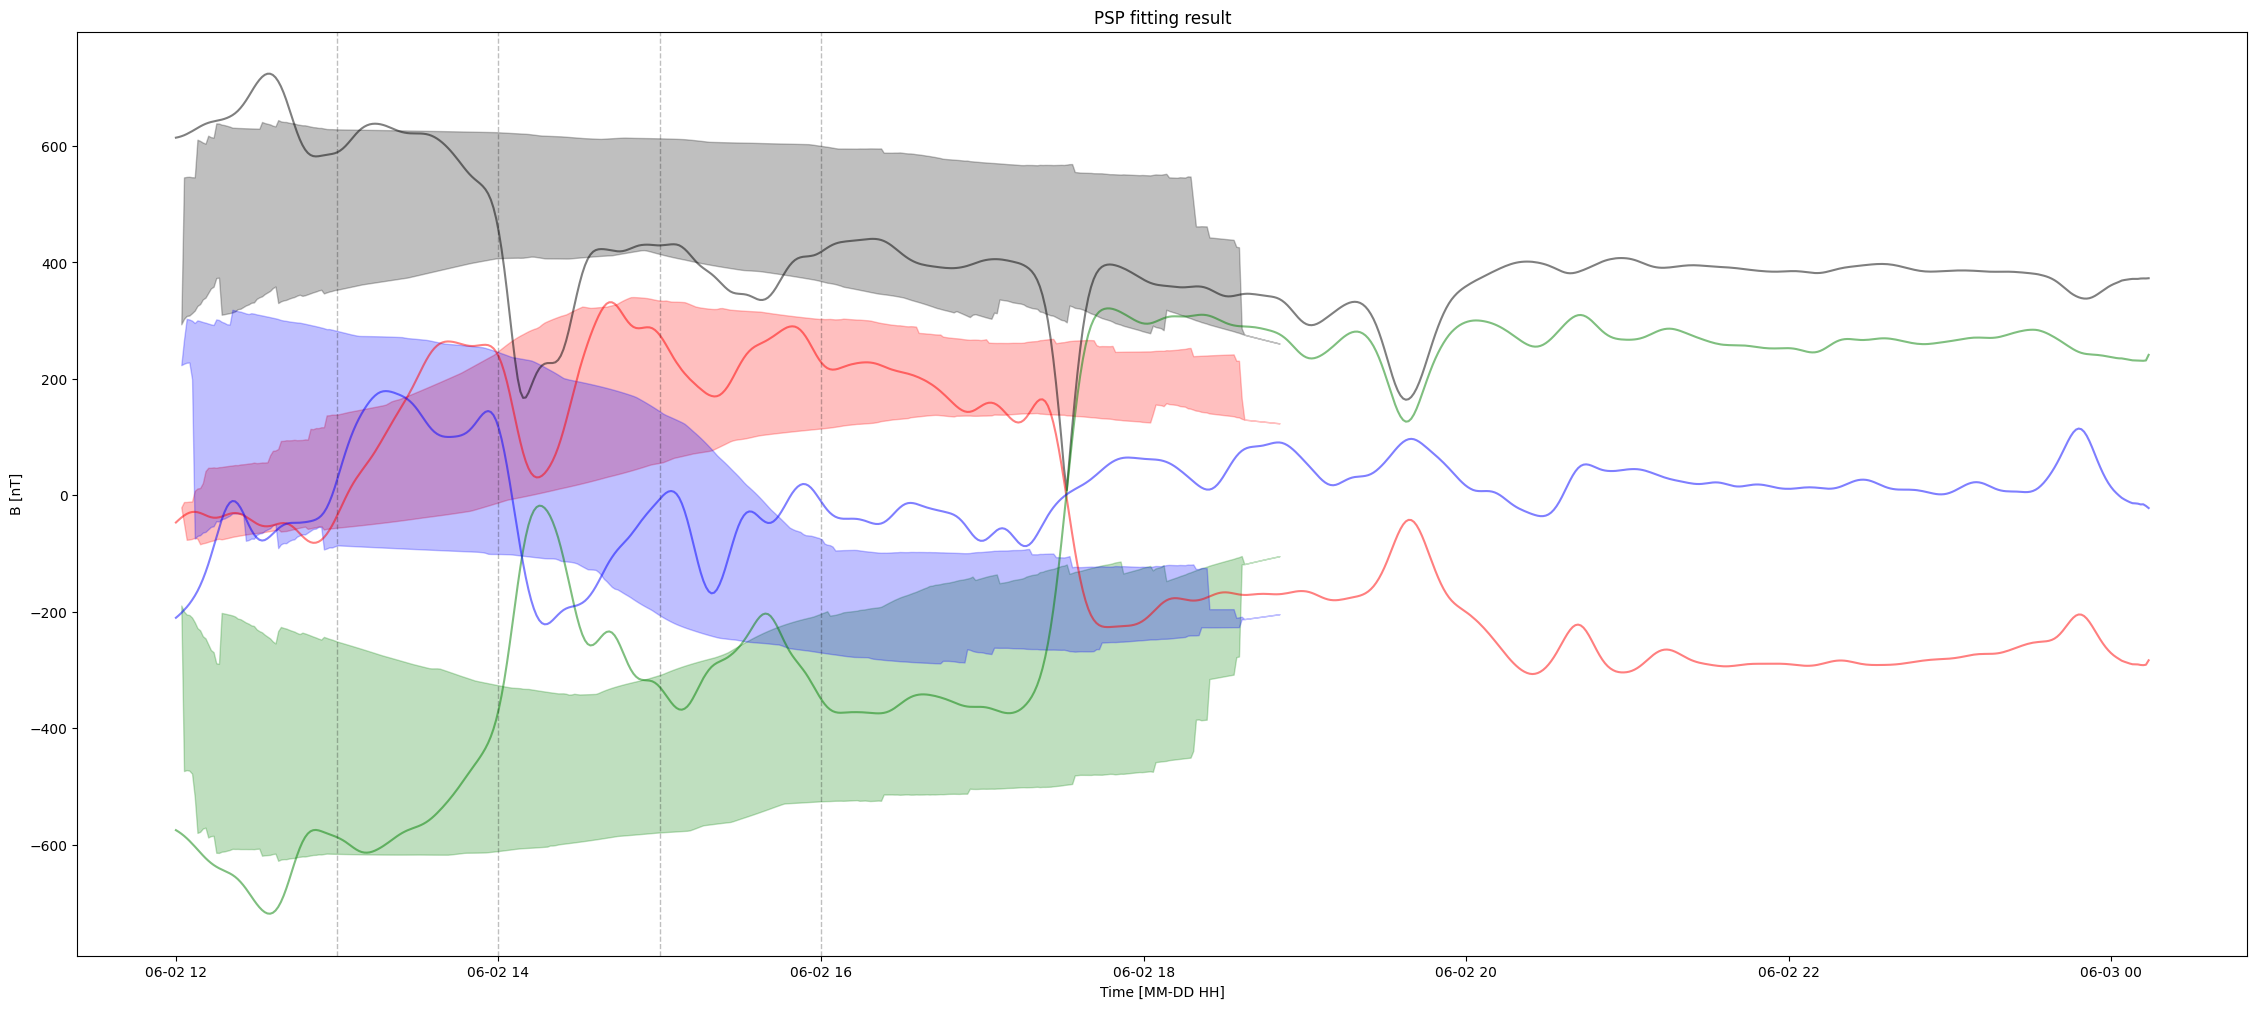

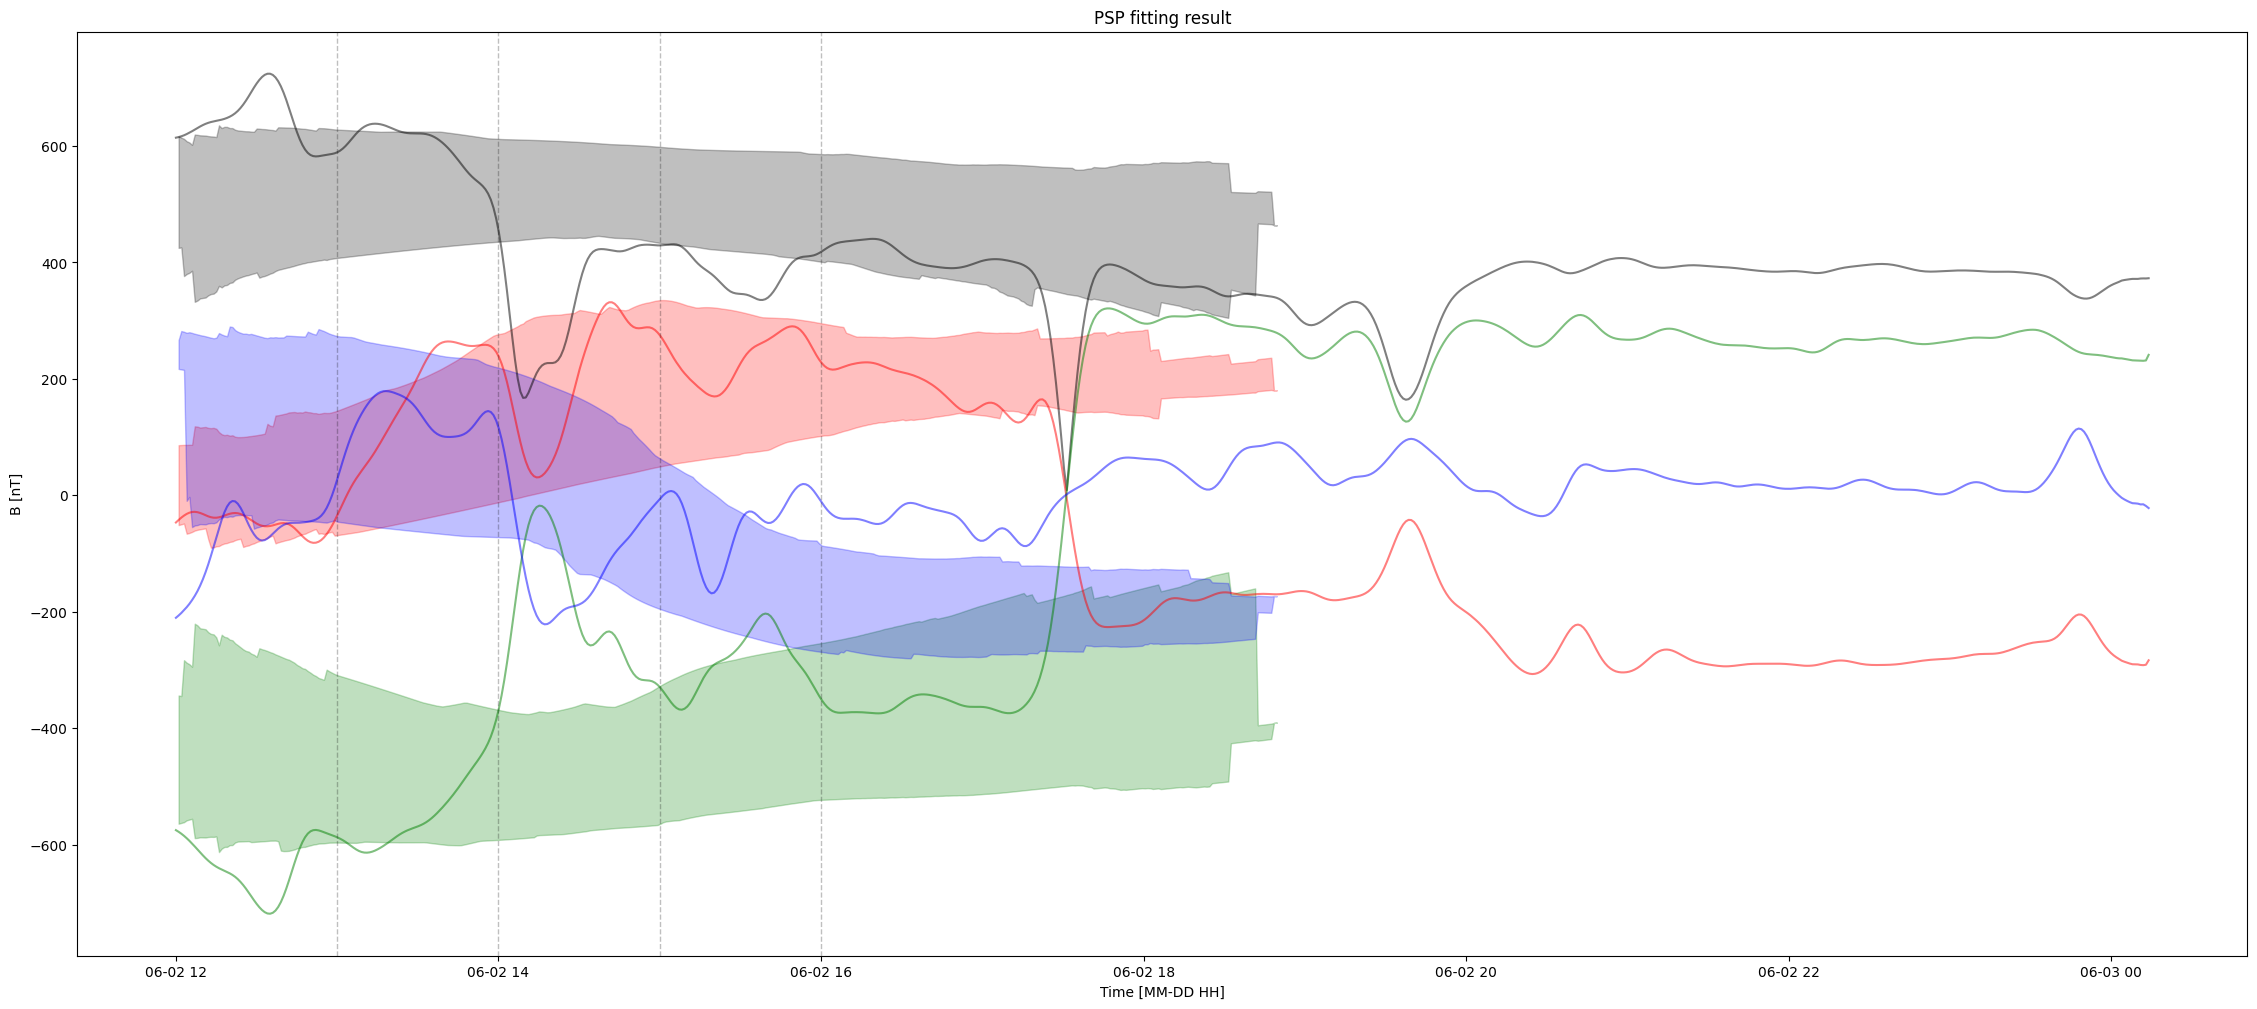

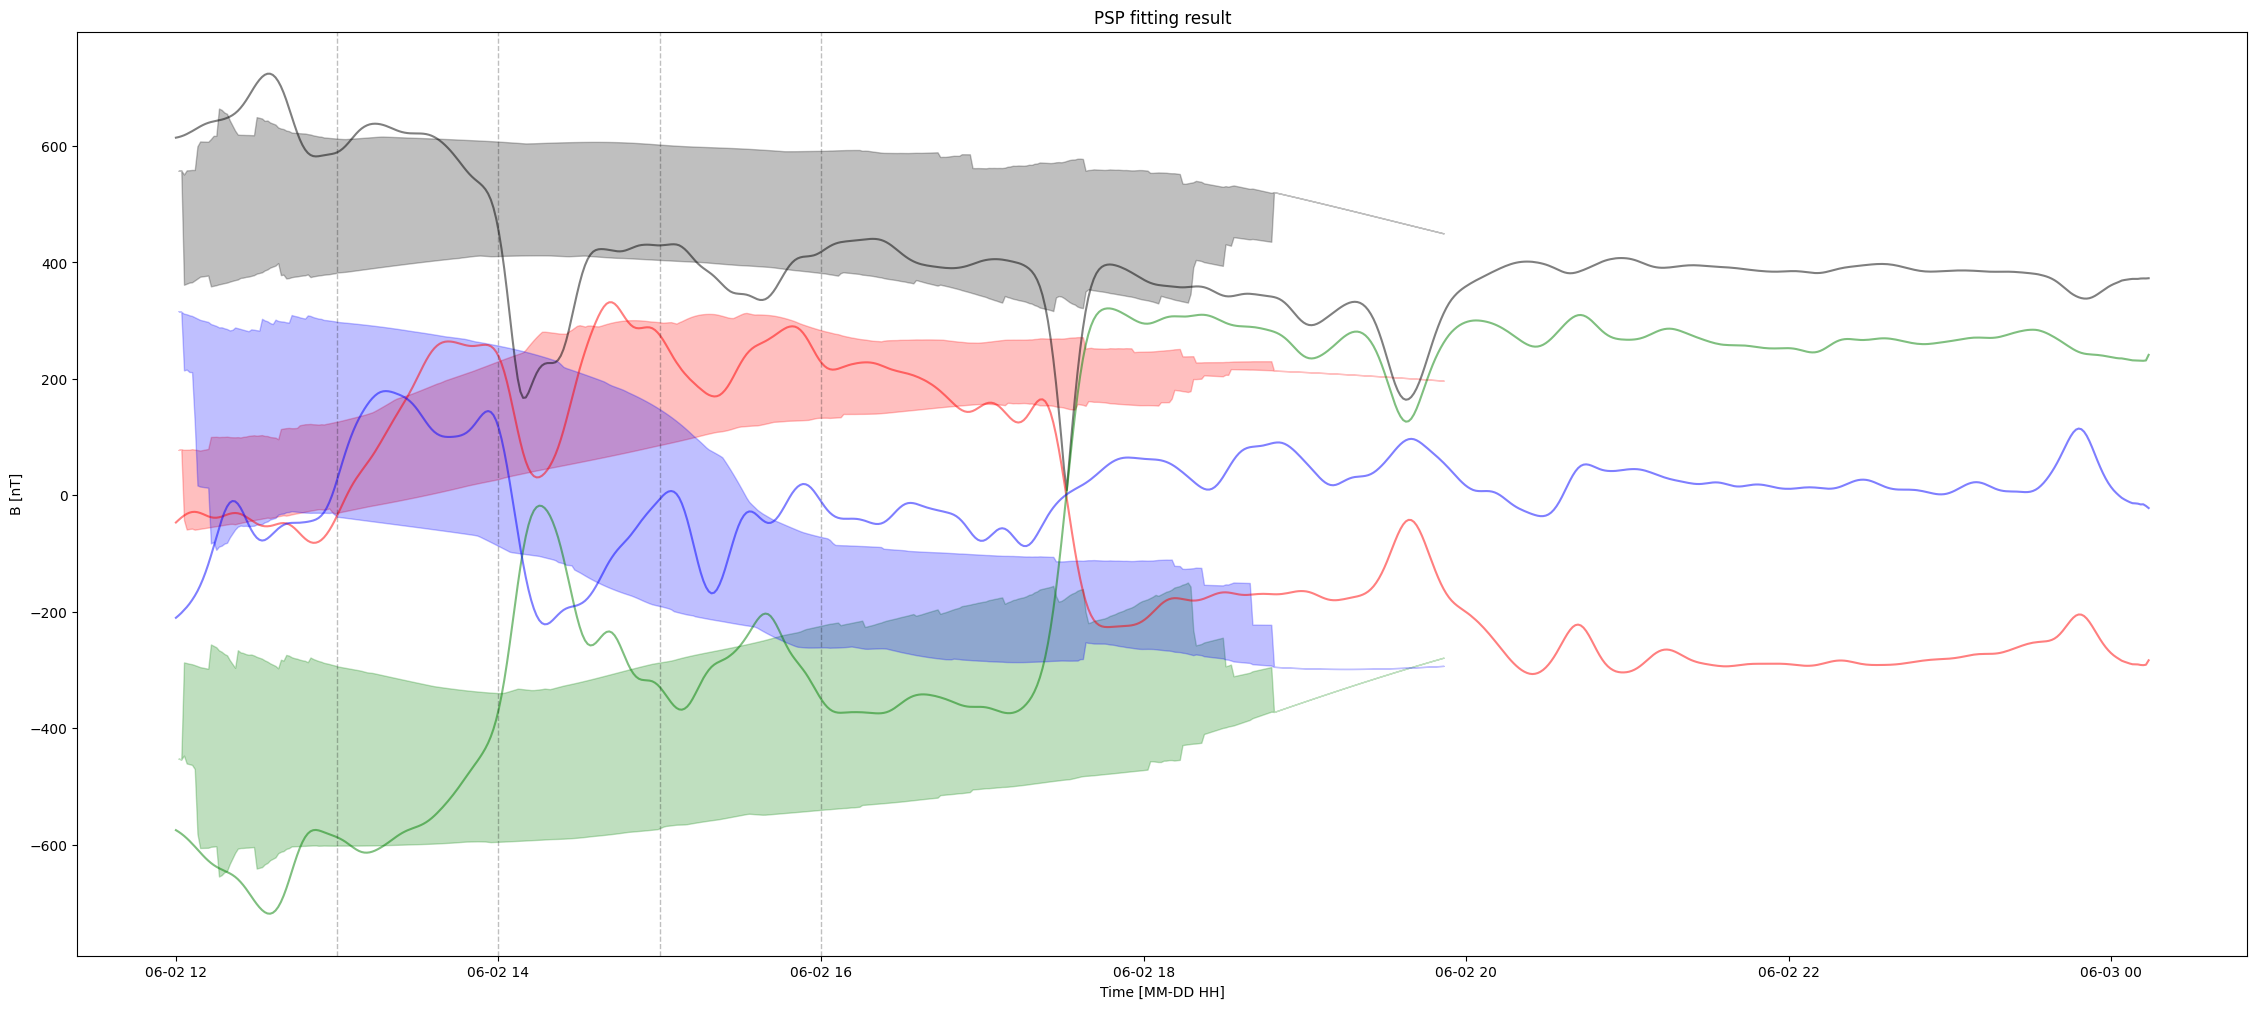

In [16]:
t_s_psp = datetime.datetime(2022, 6, 2, 12, tzinfo=datetime.timezone.utc)
t_e_psp = datetime.datetime(2022, 6, 3, 2, tzinfo=datetime.timezone.utc)

psp_t, psp_b = heliosat.PSP().get([t_s_psp, t_e_psp], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

for dirl in resfile:
    respath = path + dirl
    ed = py3dcore_h4c.generate_ensemble(respath, psp_t, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

    plt.figure(figsize=(28, 12))
    plt.title("PSP fitting result")
    plt.plot(psp_t, np.sqrt(np.sum(psp_b**2, axis=1)), "k", alpha=0.5)
    plt.plot(psp_t, psp_b[:, 0], "r", alpha=0.5)
    plt.plot(psp_t, psp_b[:, 1], "g", alpha=0.5)
    plt.plot(psp_t, psp_b[:, 2], "b", alpha=0.5)
    plt.fill_between(psp_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
    plt.fill_between(psp_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
    plt.fill_between(psp_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
    plt.fill_between(psp_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
    plt.ylabel("B [nT]")
    plt.xlabel("Time [MM-DD HH]")
    for _ in t_psp:
        plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
    plt.savefig(path+'%s.png' %dirl)
    plt.show()